# Analysis of the Stackoverflow Survey of 2017

In this notebook, some analysis on the stackoverflow survey of 2018 will be done.

The analysis is done by following the steps in the table of contents. 

## Table of Contents

I.  [Which questions should be answered?](#Exploratory-Data-Analysis)<br>
II. [Clean the data](#Clean)<br>
III. [Modelling and Analysis for each question](#Modelling)<br>

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

import seaborn as sns
from collections import defaultdict

In [41]:
df = pd.read_csv('../data/survey_results_public.csv')
df_schema = pd.read_csv('../data/survey_results_schema.csv')

# Show df to get an idea of the data
df.head()

,Respondent,Professional,ProgramHobby,Country,University,EmploymentStatus,FormalEducation,MajorUndergrad,HomeRemote,CompanySize,...,StackOverflowMakeMoney,Gender,HighestEducationParents,Race,SurveyLong,QuestionsInteresting,QuestionsConfusing,InterestedAnswers,Salary,ExpectedSalary
0,1,Student,"Yes, both",United States,No,"Not employed, and not looking for work",Secondary school,NaN,NaN,NaN,...,Strongly disagree,Male,High school,White or of European descent,Strongly disagree,Strongly agree,Disagree,Strongly agree,NaN,NaN
1,2,Student,"Yes, both",United Kingdom,"Yes, full-time",Employed part-time,Some college/university study without earning ...,Computer science or software engineering,"More than half, but not all, the time",20 to 99 employees,...,Strongly disagree,Male,A master's degree,White or of European descent,Somewhat agree,Somewhat agree,Disagree,Strongly agree,NaN,37500.0
2,3,Professional developer,"Yes, both",United Kingdom,No,Employed full-time,Bachelor's degree,Computer science or software engineering,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A professional degree,White or of European descent,Somewhat agree,Agree,Disagree,Agree,113750.0,NaN
3,4,Professional non-developer who sometimes write...,"Yes, both",United States,No,Employed full-time,Doctoral degree,A non-computer-focused engineering discipline,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A doctoral degree,White or of European descent,Agree,Agree,Somewhat agree,Strongly agree,NaN,NaN
4,5,Professional developer,"Yes, I program as a hobby",Switzerland,No,Employed full-time,Master's degree,Computer science or software engineering,Never,10 to 19 employees,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
df_schema.head()

,Column,Question
0,Respondent,Respondent ID number
1,Professional,Which of the following best describes you?
2,ProgramHobby,Do you program as a hobby or contribute to ope...
3,Country,In which country do you currently live?
4,University,"Are you currently enrolled in a formal, degree..."


In [43]:
assert df.shape[1] == df_schema.shape[0]
print('The survey contained {} questions. In total, there are {} survey responses.'.format(df.shape[1], df.shape[0]))

The survey contained 154 questions. In total, there are 19102 survey responses.


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Which questions should be answered?</a>

The schema and the data are used to find interessting questions which should be answered in the following analysis.

In [7]:
df_schema.head(n=10)

,Column,Question
0,Respondent,Respondent ID number
1,Professional,Which of the following best describes you?
2,ProgramHobby,Do you program as a hobby or contribute to ope...
3,Country,In which country do you currently live?
4,University,"Are you currently enrolled in a formal, degree..."
5,EmploymentStatus,Which of the following best describes your cur...
6,FormalEducation,Which of the following best describes the high...
7,MajorUndergrad,Which of the following best describes your mai...
8,HomeRemote,How often do you work from home or remotely?
9,CompanySize,"In terms of the number of employees, how large..."


**Questions which will be answered in the following parts:**

|#| Question | Additional Information | Helpful columns | Target column |
| ---| :--- | :---| :---| :---|
|1| Exists a correlation between "Overpaid" and "Salary", depending on the experience?  | - | YearsProgram, Overpaid, Salary | *TODO: Maybe use one to predict the other?*|
|2| Is there a programing language specific correlation between "OtherPeoplesCode - Maintaining other people's code is a form of torture" and "EnjoyDebugging -I enjoy debugging code"?| - | HaveWorkedLanguage, OtherPeoplesCode, EnjoyDebugging | *TODO: Maybe use one to predict the other?*|
|3|How many people, who program in Python, follow the PEP8 guidlines and use spaces instead of tabs?|-|HaveWorkedLanguage |TabsSpaces|
|4| Does the company influence the happiness/satisfaction of the users?  | only for employed users of a company (EmploymentStatus) | EmploymentStatus, CompanySize, CompanyType, InfluenceInternet, InfluenceWorkstation, InfluenceHardware, InfluenceServers, InfluenceTechStack, InfluenceDeptTech, InfluenceVizTools, InfluenceDatabase, InfluenceCloud, InfluenceConsultants, InfluenceRecruitment, InfluenceCommunication | CareerSatisfaction, JobSatisfaction  |


The questions have been found by looking at the df_schema in detail to find interesting questions.

### <a class="anchor" id="Clean">Part II: Clean the data</a>

In [Part |](#Exploratory-Data-Analysis) the needed columns are defined. In the following, the data is preperaded for each question. Only the needed columns are modified and cleaned.

The column *HaveWorkedLanguage* is split into separated columns, one for each programming language. This information is needed for question 3 and 4, so it is done once at the beginning on the original data.


In [44]:
# HAVE WORKED LANGUAGE - Extract available values
# convert all 'HaveWorkedLanguage' entries into lists: df_q3.HaveWorkedLanguage.str.split(';')
df['HaveWorkedLanguageList'] = df.HaveWorkedLanguage.str.split(';')
#flatten all lists to one
prog_languages = set()
for entry in df.HaveWorkedLanguageList:
    if isinstance(entry, float):
        # list(entry) is empty, so NaN is returned
        continue
    else:
        [prog_languages.add(elem.strip()) for elem in entry]


In [45]:
# convert available programming languages in columns
print(df.columns)
df[list(prog_languages)] = pd.DataFrame(data = np.zeros((df.shape[0],len(prog_languages))), columns = list(prog_languages))
print(df.columns)

Index(['Respondent', 'Professional', 'ProgramHobby', 'Country', 'University',
       'EmploymentStatus', 'FormalEducation', 'MajorUndergrad', 'HomeRemote',
       'CompanySize',
       ...
       'Gender', 'HighestEducationParents', 'Race', 'SurveyLong',
       'QuestionsInteresting', 'QuestionsConfusing', 'InterestedAnswers',
       'Salary', 'ExpectedSalary', 'HaveWorkedLanguageList'],
      dtype='object', length=155)
Index(['Respondent', 'Professional', 'ProgramHobby', 'Country', 'University',
       'EmploymentStatus', 'FormalEducation', 'MajorUndergrad', 'HomeRemote',
       'CompanySize',
       ...
       'JavaScript', 'PHP', 'F#', 'Scala', 'Java', 'Swift', 'Dart', 'SQL',
       'Ruby', 'Matlab'],
      dtype='object', length=190)


In [46]:
# Convert HaveWorkedList into binary values for the different programming languages
for idx, prog_lang_list in df.HaveWorkedLanguageList.iteritems():
    if isinstance(prog_lang_list, float):
        # list(entry) is empty, so NaN is returned
        continue
    else:
        for entry in prog_lang_list:
            entry = entry.strip()
            df.loc[df.index[idx], entry] = 1

In [47]:
df.head()

,Respondent,Professional,ProgramHobby,Country,University,EmploymentStatus,FormalEducation,MajorUndergrad,HomeRemote,CompanySize,...,JavaScript,PHP,F#,Scala,Java,Swift,Dart,SQL,Ruby,Matlab
0,1,Student,"Yes, both",United States,No,"Not employed, and not looking for work",Secondary school,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,2,Student,"Yes, both",United Kingdom,"Yes, full-time",Employed part-time,Some college/university study without earning ...,Computer science or software engineering,"More than half, but not all, the time",20 to 99 employees,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,3,Professional developer,"Yes, both",United Kingdom,No,Employed full-time,Bachelor's degree,Computer science or software engineering,"Less than half the time, but at least one day ...","10,000 or more employees",...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,4,Professional non-developer who sometimes write...,"Yes, both",United States,No,Employed full-time,Doctoral degree,A non-computer-focused engineering discipline,"Less than half the time, but at least one day ...","10,000 or more employees",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,5,Professional developer,"Yes, I program as a hobby",Switzerland,No,Employed full-time,Master's degree,Computer science or software engineering,Never,10 to 19 employees,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [145]:
# Pick the needed columns for each question
df_q1 = df[['YearsProgram', 'Overpaid']]
df_q2 = df[list(prog_languages)+['OtherPeoplesCode', 'EnjoyDebugging']]
df_q3 = df[['Python', 'TabsSpaces']]
df_q4 = df[['EmploymentStatus', 'CompanySize', 'CompanyType', 'InfluenceInternet', 'InfluenceWorkstation', 'InfluenceHardware', 
        'InfluenceServers', 'InfluenceTechStack', 'InfluenceDeptTech', 'InfluenceVizTools', 
        'InfluenceDatabase', 'InfluenceCloud', 'InfluenceConsultants', 'InfluenceRecruitment', 
        'InfluenceCommunication', 'CareerSatisfaction', 'JobSatisfaction']]


#### Cleaning for question 1: Exists a correlation between *Overpaid* and the programming experience?

In [130]:
# Calculation makes only sense if both values are available
df_q1 = df_q1.dropna(subset = ['Overpaid'])
print('The number of survey responsdents reduced from {} to {}.'.format(df.shape[0], df_q1.shape[0]))

The number of survey responsdents reduced from 19102 to 5184.


In [131]:
## YEARS PROGRAM
# Create a nested dictionary which matches the years of experience with the overpaid rate
q1_dict_experience = defaultdict(dict)

for key, data in df_q1.groupby(by=['YearsProgram', 'Overpaid']):
    experience = key[0]
    overpaid_target = key[1]
    value = data.YearsProgram.count()
    q1_dict_experience[experience][overpaid_target] = value
    
print(q1_dict_experience)

defaultdict(<class 'dict'>, {'1 to 2 years': {'Greatly underpaid': 17, 'Neither underpaid nor overpaid': 31, 'Somewhat overpaid': 4, 'Somewhat underpaid': 31}, '10 to 11 years': {'Greatly overpaid': 2, 'Greatly underpaid': 34, 'Neither underpaid nor overpaid': 113, 'Somewhat overpaid': 20, 'Somewhat underpaid': 135}, '11 to 12 years': {'Greatly overpaid': 1, 'Greatly underpaid': 21, 'Neither underpaid nor overpaid': 72, 'Somewhat overpaid': 9, 'Somewhat underpaid': 95}, '12 to 13 years': {'Greatly overpaid': 1, 'Greatly underpaid': 17, 'Neither underpaid nor overpaid': 69, 'Somewhat overpaid': 13, 'Somewhat underpaid': 92}, '13 to 14 years': {'Greatly underpaid': 14, 'Neither underpaid nor overpaid': 68, 'Somewhat overpaid': 14, 'Somewhat underpaid': 60}, '14 to 15 years': {'Greatly overpaid': 3, 'Greatly underpaid': 21, 'Neither underpaid nor overpaid': 96, 'Somewhat overpaid': 13, 'Somewhat underpaid': 128}, '15 to 16 years': {'Greatly overpaid': 1, 'Greatly underpaid': 23, 'Neither 

In [132]:
## Convert Overpaid column to numeric target column
#label_encoder = LabelEncoder()
#target_column = label_encoder.fit_transform(df_q1.Overpaid)
#df_q1['target'] = target_column
##df_q2 = df_q2.drop(labels=['Overpaid'], axis = 1)
#print(df_q1.head())

In [133]:
## OVERPAID
#print('Answer possibilities for Overpaid: ',df_q1.Overpaid.unique())
## remove entries which do not provide additional information
#df_q1 = df_q1.dropna(axis = 0, subset=['Overpaid'])
#print(df_q1.shape)
#tmp = pd.get_dummies(df_q1.Overpaid, prefix='Overpaid')
#print(tmp.shape)
#df_q1[tmp.columns] = tmp
#print(df_q1.shape)
#df_q1 = df_q1.drop(labels=['Overpaid'], axis = 1)

#### Cleaning for question 2: Is there a programing language specific correlation between "OtherPeoplesCode - Maintaining other people's code is a form of torture" and "EnjoyDebugging -I enjoy debugging code"?

In [146]:
# Calculation makes only sense if both values 'OtherPeoplesCode' and 'EnjoyDebugging' are available
df_q2 = df_q2.dropna(subset = ['EnjoyDebugging', 'OtherPeoplesCode'], how = 'any')
#df_q2 = df_q2.reset_index(drop = True)
print('The number of survey responsdents reduced from {} to {}.'.format(df.shape[0], df_q2.shape[0]))

The number of survey responsdents reduced from 19102 to 11148.


In [25]:
# OTHER PEOPLE CODE
tmp = pd.get_dummies(df_q2.OtherPeoplesCode, prefix='OtherPeoplesCode', prefix_sep='_')
#print(tmp.shape)
df_q2[tmp.columns] = tmp
#print(df_q1.shape)
df_q2 = df_q2.drop(labels=['OtherPeoplesCode'], axis = 1)

In [26]:
# ENJOY DEBUGGING
tmp = pd.get_dummies(df_q2.EnjoyDebugging, prefix='EnjoyDebugging', prefix_sep='_')
#print(tmp.shape)
df_q2[tmp.columns] = tmp
#print(df_q1.shape)
df_q2 = df_q2.drop(labels=['EnjoyDebugging'], axis = 1)

In [27]:
df_q2.head()

,C++,TypeScript,Assembly,Python,C#,Haskell,VB.NET,Rust,VBA,C,...,OtherPeoplesCode_Agree,OtherPeoplesCode_Disagree,OtherPeoplesCode_Somewhat agree,OtherPeoplesCode_Strongly agree,OtherPeoplesCode_Strongly disagree,EnjoyDebugging_Agree,EnjoyDebugging_Disagree,EnjoyDebugging_Somewhat agree,EnjoyDebugging_Strongly agree,EnjoyDebugging_Strongly disagree
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,1,0,0,0,0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,1,0,0,0,0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,1,0,0
7,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,1,0,0,0,0
8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,1,0,0,0,0


#### Cleaning for question 3: How many people, who program in Python, follow the PEP8 guidlines and use spaces instead of tabs?

In [28]:
# Extract only the people who programm in Python
print(df_q3.head())
df_q3 = df_q3[df_q3.Python == 1]
print(df_q3.head())

   Python TabsSpaces
0     0.0       Tabs
1     1.0     Spaces
2     1.0     Spaces
3     1.0     Spaces
4     0.0        NaN
   Python TabsSpaces
1     1.0     Spaces
2     1.0     Spaces
3     1.0     Spaces
6     1.0     Spaces
7     1.0     Spaces


In [29]:
# TABS SPACES
tmp = pd.get_dummies(df_q3.TabsSpaces, prefix='TabsSpaces', prefix_sep='_')
#print(tmp.shape)
df_q3[tmp.columns] = tmp
#print(df_q1.shape)
df_q3 = df_q3.drop(labels=['TabsSpaces'], axis = 1)

#### Cleaning for question 4: Does the company influence the happiness/satisfaction of the users?

In [13]:
df_q4.head()

,EmploymentStatus,CompanySize,CompanyType,InfluenceInternet,InfluenceWorkstation,InfluenceHardware,InfluenceServers,InfluenceTechStack,InfluenceDeptTech,InfluenceVizTools,InfluenceDatabase,InfluenceCloud,InfluenceConsultants,InfluenceRecruitment,InfluenceCommunication,CareerSatisfaction,JobSatisfaction
0,"Not employed, and not looking for work",NaN,NaN,Not very satisfied,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Employed part-time,20 to 99 employees,"Privately-held limited company, not in startup...",Satisfied,No influence at all,No influence at all,No influence at all,No influence at all,No influence at all,No influence at all,No influence at all,No influence at all,No influence at all,No influence at all,No influence at all,NaN,NaN
2,Employed full-time,"10,000 or more employees",Publicly-traded corporation,Very satisfied,A lot of influence,Some influence,Some influence,Some influence,A lot of influence,Some influence,Some influence,Some influence,Some influence,Some influence,Some influence,8.0,9.0
3,Employed full-time,"10,000 or more employees",Non-profit/non-governmental organization or pr...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,3.0
4,Employed full-time,10 to 19 employees,"Privately-held limited company, not in startup...",Satisfied,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,8.0


In [14]:
# EMPLOYMENT STATUS - Question 1 is only relevant for people who work in a company
print('Answer possibilities for EmploymentStatus: ',df_q4.EmploymentStatus.unique())
df_q4 = df_q4[df_q4.EmploymentStatus.isin(['Employed full-time', 'Employed part-time'])]
df_q4 = df_q4.drop(labels = ['EmploymentStatus'],axis = 1)
print('The number of survey responsed reduced from {} to {}.'.format(df.shape[0], df_q4.shape[0]))

Answer possibilities for EmploymentStatus:  ['Not employed, and not looking for work' 'Employed part-time'
 'Employed full-time'
 'Independent contractor, freelancer, or self-employed'
 'Not employed, but looking for work' 'I prefer not to say' 'Retired']
The number of survey responsed reduced from 19102 to 14823.


In [15]:
# COMPANY SIZE
print('Answer possibilities for CompanySize: ',df_q4.CompanySize.unique())
# remove entries which do not provide additional information
df_q4.CompanySize = df_q4.CompanySize.replace(["I don't know", "I prefer not to answer"], np.NaN)
df_q4 = df_q4.dropna(axis = 0, subset=['CompanySize'])
#print(df_q4.shape)
#df_q4 = pd.concat([df_q4, pd.get_dummies(df_q4.CompanySize, prefix='CompanySize')], ignore_index = True)
tmp = pd.get_dummies(df_q4.CompanySize, prefix='CompanySize')
#print(tmp.shape)
df_q4[tmp.columns] = tmp
#print(df_q4.shape)
df_q4 = df_q4.drop(labels=['CompanySize'], axis = 1)
#print(df_q4.columns)

Answer possibilities for CompanySize:  ['20 to 99 employees' '10,000 or more employees' '10 to 19 employees'
 'Fewer than 10 employees' '5,000 to 9,999 employees'
 '100 to 499 employees' '1,000 to 4,999 employees' '500 to 999 employees'
 "I don't know" nan 'I prefer not to answer']


In [16]:
# COMPANY TYPE
print('Answer possibilities for CompanyTypeSize: ',df_q4.CompanyType.unique())
# remove entries which do not provide additional information
df_q4.CompanyType = df_q4.CompanyType.replace(["I don't know", "I prefer not to answer"], np.NaN)
df_q4 = df_q4.dropna(axis = 0, subset=['CompanyType'])
#print(df_q4.shape)
# df_q4 = pd.concat([df_q4, pd.get_dummies(df_q4.CompanyType, prefix='CompanyType')])
tmp = pd.get_dummies(df_q4.CompanyType, prefix='CompanyType')
#print(tmp.shape)
df_q4[tmp.columns] = tmp
#print(df_q4.shape)
df_q4 = df_q4.drop(labels=['CompanyType'], axis = 1)
#print(df_q4.columns)

Answer possibilities for CompanyTypeSize:  ['Privately-held limited company, not in startup mode'
 'Publicly-traded corporation'
 'Non-profit/non-governmental organization or private school/university'
 'Government agency or public school/university' 'Pre-series A startup'
 'Venture-funded startup' "I don't know"
 'Sole proprietorship or partnership, not in startup mode'
 'I prefer not to answer' 'State-owned company' 'Something else' nan]


In [17]:
# INFLUENCE
influence_columns = ['InfluenceInternet', 'InfluenceWorkstation', 'InfluenceHardware', 
        'InfluenceServers', 'InfluenceTechStack', 'InfluenceDeptTech', 'InfluenceVizTools', 
        'InfluenceDatabase', 'InfluenceCloud', 'InfluenceConsultants', 'InfluenceRecruitment', 
        'InfluenceCommunication']
for column in influence_columns:
    df_q4 = df_q4.dropna(axis = 0, subset=[column])
    tmp = pd.get_dummies(df_q4[column], prefix=column)
    #print(tmp.shape)
    df_q4[tmp.columns] = tmp
    #print(df_q1.shape)
    df_q4 = df_q4.drop(labels=[column], axis = 1)

    
    #df_q1 = df_q1.dropna(axis = 0, subset=[column])
    #df_q1 = pd.concat([df_q1, pd.get_dummies(df_q1[column], prefix=column)])
    #df_q1 = df_q1.drop(labels=[column], axis = 1)
#unique_values


In [18]:
# JOB SATISFACTION
mean = int(df_q4.JobSatisfaction.mean())
# as the satisfaction is on a scale, the mean has been converted to an integer as well
df_q4.JobSatisfaction = df_q4.JobSatisfaction.fillna(mean)

In [19]:
# CAREER SATISFACTION
mean = int(df_q4.CareerSatisfaction.mean())
# as the satisfaction is on a scale, the mean has been converted to an integer as well
df_q4.CareerSatisfaction = df_q4.CareerSatisfaction.fillna(mean)

### <a class="anchor" id="Modelling">Part III: Modelling and Analysis for each question</a>

#### Analysis for question 1: Exists a correlation between *Overpaid* and the programming experience?

In [134]:
df_q1.head()

,YearsProgram,Overpaid
2,20 or more years,Neither underpaid nor overpaid
8,13 to 14 years,Neither underpaid nor overpaid
14,20 or more years,Somewhat underpaid
17,20 or more years,Neither underpaid nor overpaid
18,2 to 3 years,Somewhat overpaid


In [136]:
# To get comparable values, the values have to be set into relation to the total entries in this YearsProgram value
for key1, elem in df_q1.groupby(by=['YearsProgram'])['Overpaid']:
    for key2 in q1_dict_experience[key1]:
        q1_dict_experience[key1][key2] = (q1_dict_experience[key1][key2]/elem.count())*100

In [137]:
key2 = 'Greatly underpaid'
greatly_underpaid = [q1_dict_experience[key1][key2] if key2 in q1_dict_experience[key1].keys() else 0 for key1 in q1_dict_experience.keys()]
key2 = 'Somewhat underpaid'
underpaid = [q1_dict_experience[key1][key2] if key2 in q1_dict_experience[key1].keys() else 0 for key1 in q1_dict_experience.keys()]
key2 = 'Neither underpaid nor overpaid'
neither = [q1_dict_experience[key1][key2] if key2 in q1_dict_experience[key1].keys() else 0 for key1 in q1_dict_experience.keys()]
key2 = 'Somewhat overpaid'
overpaid = [q1_dict_experience[key1][key2] if key2 in q1_dict_experience[key1].keys() else 0 for key1 in q1_dict_experience.keys()]
key2 = 'Greatly overpaid'
greatly_overpaid = [q1_dict_experience[key1][key2] if key2 in q1_dict_experience[key1].keys() else 0 for key1 in q1_dict_experience.keys()]

In [138]:
bottom_p3 = [x + y for x, y in zip(underpaid, greatly_underpaid)]
bottom_p4 = [x + y for x, y in zip(bottom_p3, neither)]
bottom_p5 = [x + y for x, y in zip(bottom_p4, overpaid)]

<class 'list'>
<class 'list'>


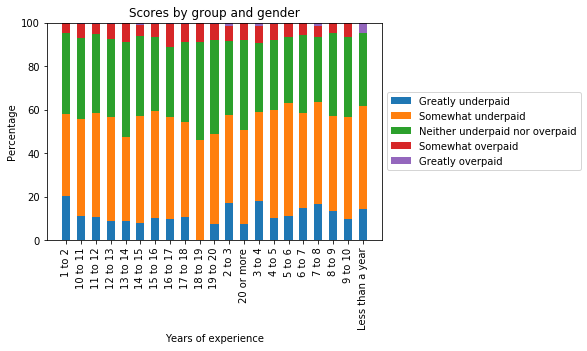

<Figure size 432x288 with 0 Axes>

In [139]:
N = len(greatly_overpaid)
ind = np.arange(N)    # the x locations for the groups
width = 0.55       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, greatly_underpaid, width)
p2 = plt.bar(ind, underpaid, width,
             bottom=greatly_underpaid)
p3 = plt.bar(ind, neither, width,
             bottom=bottom_p3)
p4 = plt.bar(ind, overpaid, width,
             bottom=bottom_p4)
p5 = plt.bar(ind, greatly_overpaid, width,
             bottom=bottom_p5)

plot_xticks = [elem.split(' years')[0] for elem in list(q1_dict_experience.keys())]

plt.ylabel('Percentage')
plt.title('Scores by group and gender')
plt.xticks(ind, plot_xticks, rotation='vertical')#('0-5', '5-10', '10-15', '15+'))
plt.xlabel('Years of experience')
#plt.yticks(np.arange(0, 81, 10))
plt.legend((p1[0], p2[0], p3[0], p4[0], p5[0]), 
           ('Greatly underpaid', 'Somewhat underpaid', 'Neither underpaid nor overpaid', 'Somewhat overpaid', 'Greatly overpaid'),loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()
plt.savefig('test.png', bbox_inches='tight')

#### Analysis for question 2: Is there a programing language specific correlation between "OtherPeoplesCode - Maintaining other people's code is a form of torture" and "EnjoyDebugging -I enjoy debugging code"?

In [147]:
df_q2.head()

,C++,TypeScript,Assembly,Python,C#,Haskell,VB.NET,Rust,VBA,C,...,F#,Scala,Java,Swift,Dart,SQL,Ruby,Matlab,OtherPeoplesCode,EnjoyDebugging
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,Disagree,Agree
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Disagree,Agree
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,Agree,Somewhat agree
7,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Somewhat agree,Agree
8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Somewhat agree,Agree


In [148]:
target_columns = [elem for elem in df_q2.columns if elem not in list(prog_languages)]
print(target_columns)

['OtherPeoplesCode', 'EnjoyDebugging']


In [152]:
df_q2

,C++,TypeScript,Assembly,Python,C#,Haskell,VB.NET,Rust,VBA,C,...,F#,Scala,Java,Swift,Dart,SQL,Ruby,Matlab,OtherPeoplesCode,EnjoyDebugging
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,Disagree,Agree
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Disagree,Agree
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,Agree,Somewhat agree
7,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Somewhat agree,Agree
8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Somewhat agree,Agree
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Somewhat agree,Agree
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,Disagree,Agree
12,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Agree,Somewhat agree
13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,Disagree,Somewhat agree
14,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Agree,Agree


      OtherPeoplesCode  EnjoyDebugging
1             Disagree           Agree
2             Disagree           Agree
3                Agree  Somewhat agree
7       Somewhat agree           Agree
8       Somewhat agree           Agree
9       Somewhat agree           Agree
10            Disagree           Agree
12               Agree  Somewhat agree
13            Disagree  Somewhat agree
14               Agree           Agree
15            Disagree           Agree
19               Agree        Disagree
21      Strongly agree        Disagree
22            Disagree  Somewhat agree
23            Disagree           Agree
26      Somewhat agree  Strongly agree
33      Somewhat agree        Disagree
34               Agree           Agree
37            Disagree           Agree
38            Disagree           Agree
44      Strongly agree  Somewhat agree
45            Disagree           Agree
46            Disagree           Agree
47      Somewhat agree           Agree
49      Somewhat agree  S

ValueError: zero-size array to reduction operation minimum which has no identity

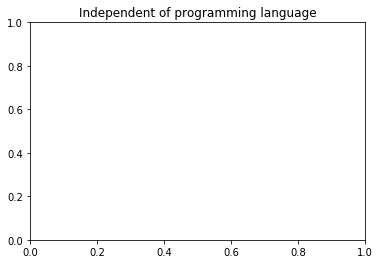

In [153]:
corr_df_q2 = df_q2[target_columns]
print(corr_df_q2)

corr = corr_df_q2.corr()
print(corr)
plt.title('Independent of programming language')
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

ValueError: zero-size array to reduction operation minimum which has no identity

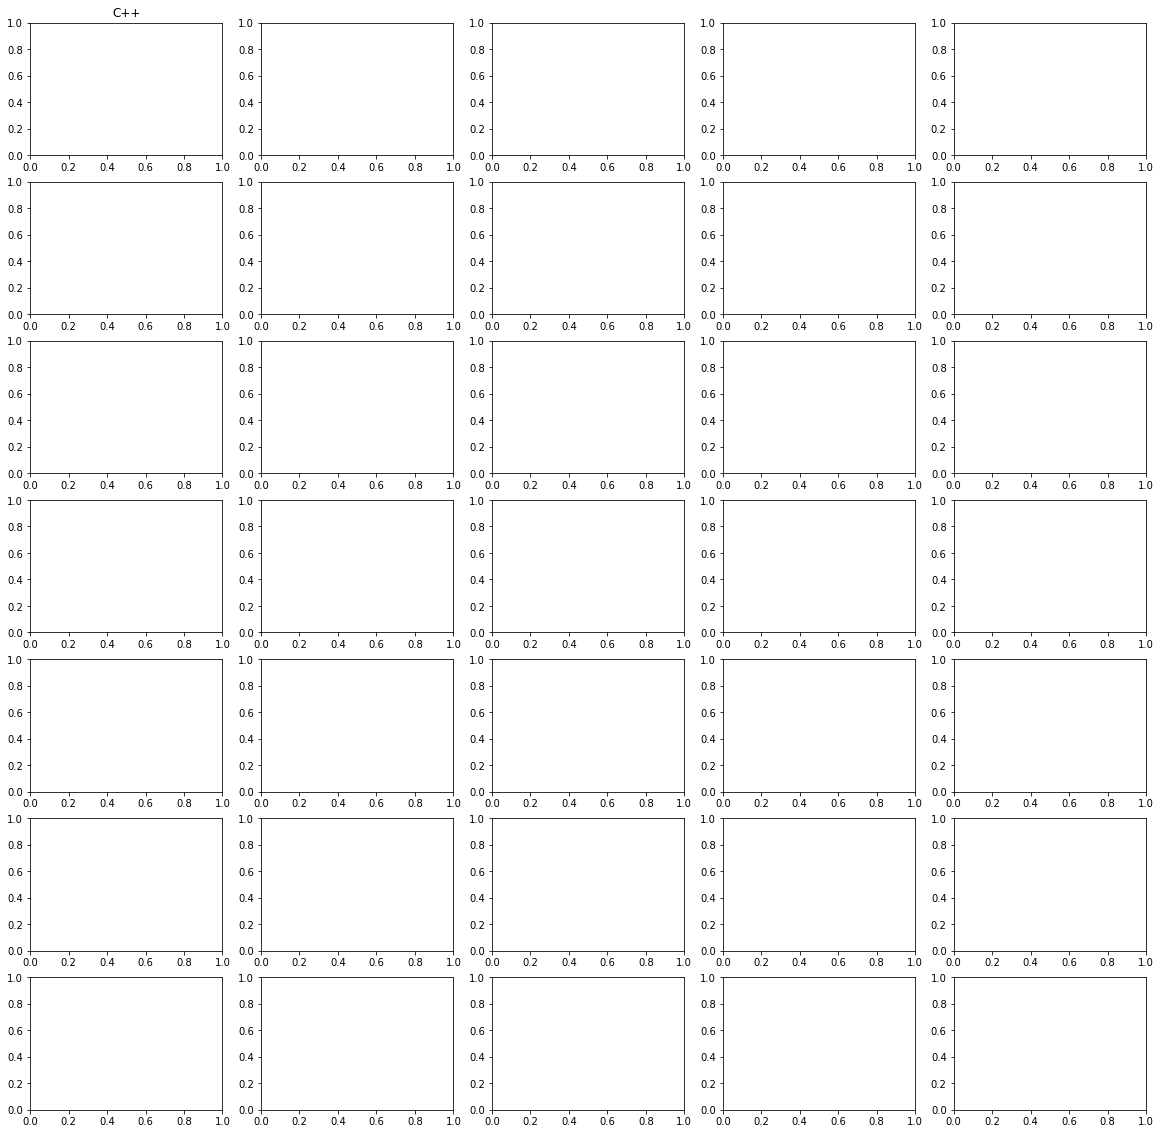

In [154]:
# Organizing plots
fig, axs = plt.subplots(7,5, figsize=(20, 20), facecolor='w', edgecolor='k')
#axs = axs.ravel()
#print(target_columns)
#

for idx, language in enumerate(prog_languages):
    # Only users who use this language are regarded
    tmp = df_q2[df_q2[language] == 1]
    #print(tmp)
    corr_df_q2 = tmp[target_columns]
    corr = corr_df_q2.corr()
    
    
    plt.subplot(7,5,idx+1) 
    # https://jakevdp.github.io/PythonDataScienceHandbook/04.08-multiple-subplots.html#plt.subplot:-Simple-Grids-of-Subplots
    plt.title(language)
    sns.heatmap(corr, xticklabels=[], yticklabels=[])


#### Analysis for question 3: How many people, who program in Python, follow the PEP8 guidlines and use spaces instead of tabs?

In [ ]:
df_q3.head()

This question aims at a percentage, not a prediction. Therefore, no attempt to apply a machine learning model was made.

In [ ]:
sum_spaces = df_q3.TabsSpaces_Spaces.sum()
sum_tabs = df_q3.TabsSpaces_Tabs.sum()
sum_both = df_q3.TabsSpaces_Both.sum()
print('{} Stackoverflow users who programm in Python use Spaces, '
      'as it is suggested by the PEP8 guidelines. This are {:.2f}% of all python users in this survey.'
      .format(sum_spaces, (sum_spaces/df_q3.shape[0])*100))


print('{} of the survey participants which programm in Python have not '
      'heard about PEP8 yet and use tabs for indentation. Hopefully this number will decrease.'.format(sum_tabs))

print('Only {:.2f}% of the Python programmers write a mixture of tabs and spaces. If they are only programming '
      'Python, this means that they use Python 2, because Python 3 does not allow '
      'a mixing of tabs and spaces anymore.'
      .format((sum_both/df_q3.shape[0])*100))

#### Modelling for question 4: Does the company influence the happiness/satisfaction of the users?
As the data has already be preprocessed, the pipeline only contain the machine learning classifier.

In [30]:
df_q4.head()

,CareerSatisfaction,JobSatisfaction,"CompanySize_1,000 to 4,999 employees",CompanySize_10 to 19 employees,"CompanySize_10,000 or more employees",CompanySize_100 to 499 employees,CompanySize_20 to 99 employees,"CompanySize_5,000 to 9,999 employees",CompanySize_500 to 999 employees,CompanySize_Fewer than 10 employees,...,InfluenceRecruitment_A lot of influence,InfluenceRecruitment_I am the final decision maker,InfluenceRecruitment_No influence at all,InfluenceRecruitment_Not much influence,InfluenceRecruitment_Some influence,InfluenceCommunication_A lot of influence,InfluenceCommunication_I am the final decision maker,InfluenceCommunication_No influence at all,InfluenceCommunication_Not much influence,InfluenceCommunication_Some influence
1,7.0,7.0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0
2,8.0,9.0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
6,7.0,6.0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,1,0
7,7.0,7.0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,1
8,6.0,6.0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0


**Prediction of Career Satisfaction**

In [ ]:
# Logistic Regression with Gridsearch

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn import metrics
from sklearn.ensemble import GradientBoostingRegressor

X = df_q4.drop(labels=['CareerSatisfaction', 'JobSatisfaction'],axis=1)
Y = df_q4.CareerSatisfaction

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3)

params = {
    'n_estimators': [100, 200], 
    'max_depth': [4, 10], 
    'min_samples_split': [2, 5, 10],
    'learning_rate': [0.01, 0.1, 0.5], 
    'loss': ['ls', 'lad', 'huber', 'quantile'] # ls - least squares regression
}

dt =  GradientBoostingRegressor()
lr_gs = GridSearchCV(dt, params, cv=3, verbose=1).fit(X_train, Y_train)

print("Best Params", lr_gs.best_params_)
print("Best Score", lr_gs.best_score_)

#lr_best = LogisticRegression(plug in best params here)
#lr_best.fit(X_train, y_train)
#lr_best.score(X_test, y_test)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


**Prediction of JobSatisfaction**

In [33]:
'TODO'

'TODO'